In [1]:
# 导入相关模块
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

In [2]:
def compute_distances(X_test: np.ndarray, X_train: np.ndarray) -> np.ndarray:
    """计算测试样本与训练样本之间的欧氏距离矩阵

    对应书中代码清单 6-2。利用矩阵完全平方公式展开优化计算速度：
    (x - y)^2 = x^2 + y^2 - 2xy

    Args:
        X_test (np.ndarray): 测试样本实例矩阵，形状为 (num_test, num_features),
                        就当前示例的形状而言，为45个数据4个特征(45x4)
        X_train (np.ndarray): 训练样本实例矩阵，形状为 (num_train, num_features)
                              就当前示例的形状而言，为105个数据4个特征(105x4)

    Returns:
        np.ndarray: 欧式距离矩阵 dists，形状为 (num_test, num_train)。
                    dists[i, j] 表示第 i 个测试样本与第 j 个训练样本之间的欧氏距离。
    """
    # 初始化距离矩阵 dists = np.zeros((num_test, num_train))
    dists = np.zeros((X_test.shape[0], X_train.shape[0]))
    # 计算测试样本与训练样本的矩阵点乘 (对应书中变量 M，此时的形状为45x105)
    M = X_test @ X_train.T
    # 分别计算测试样本和训练样本的平方和 (对应书中变量 te(45, )和 tr(105, ))
    te = np.sum(X_test**2, axis=1)
    tr = np.sum(X_train**2, axis=1)
    # 应用公式计算欧氏距离：sqrt(-2 * M + tr + te)
    # M的形状为(45, 105)，tr的形状为(105, )，te的形状为(45, )
    # 结果的形状与M一致均为(45, 105)
    dists = np.sqrt(-2 * M + tr + np.matrix(te).T)
    return dists

In [3]:
def predict_labels(y_train: np.ndarray, dists: np.ndarray, k: int = 1) -> np.ndarray:
    """根据距离矩阵预测测试样本的类别标签

    对应书中代码清单 6-4。
    逻辑：
    1. 遍历每个测试样本。
    2. 对距离进行排序 (argsort)，找到最近的 k 个训练样本的索引。
    3. 获取这 k 个邻居的标签。
    4. 使用分类决策规则（多数表决）确定预测类别。

    Args:
        y_train (np.ndarray): 训练集标签向量，形状为 (num_train, ) 或 (num_train, 1)
        dists (np.ndarray): 测试集与训练集之间的欧氏距离矩阵，由 compute_distances 计算得到
        k (int): k近邻的 k 值，默认为 1

    Returns:
        np.ndarray: 测试集预测结果向量 y_pred，形状为 (num_test, )
    """
    # 初始化预测结果数组 y_pred
    y_pred = np.zeros((dists.shape[0]))
    # 遍历测试集 (num_test)
    for i in range(dists.shape[0]):
        # 使用 np.argsort 找到距离最近的 k 个训练样本的索引
        dist_index = np.argsort(dists[i])
        # 获取这 k 个最近邻居的标签 (y_train 中对应的标签)
        labels = y_train[dist_index.T[:k]]
        # 使用 collections.Counter 进行多数表决 (most_common)，得出预测类别
        c = Counter(labels.flatten())
        pred = c.most_common(1)[0][0]
        # 存储预测结果
        y_pred[i] = pred

    return y_pred

In [4]:
def calculate_accuracy(y_true, y_pred):
    """
    计算分类准确率

    Args:
        y_true: 真实标签
        y_pred: 预测标签

    Returns:
        int: 正确的个数
        float: 准确率 (0.0 ~ 1.0)
    """
    # 确保维度一致 (对应书中 y_test_pred.reshape((-1, 1)))
    # 这是一个防御性编程的好习惯
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    # 找出预测正确的实例
    num_correct = np.sum(y_true == y_pred)

    # 计算准确率 (对应书中 accuracy)
    # 这里的 shape[0] 就是样本数量
    accuracy = float(num_correct) / y_true.shape[0]

    return num_correct, accuracy

In [5]:
# 导入sklearn iris数据集
iris = datasets.load_iris()
# 打乱数据后的数据与标签
X, y = shuffle(iris.data, iris.target, random_state=13)
# 数据转换为float32格式
X = X.astype(np.float32)
# 训练集与测试集的简单划分，训练-测试比例为7：3
offset = int(X.shape[0] * 0.7)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
# 将标签转换为竖向量
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
# 打印训练集和测试集大小
print('X_train =', X_train.shape)
print('X_test =', X_test.shape)
print('y_train =', y_train.shape)
print('y_test =', y_test.shape)

X_train = (105, 4)
X_test = (45, 4)
y_train = (105, 1)
y_test = (45, 1)


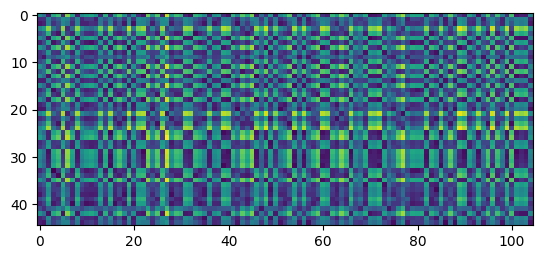

In [6]:
dists = compute_distances(X_test, X_train)
plt.imshow(dists, interpolation='none')
plt.show();

In [7]:
# 测试集预测结果
y_test_pred = predict_labels(y_train, dists, k=1)
# 计算准确率
num_correct, accuracy = calculate_accuracy(y_test, y_test_pred)
print('Got %d/%d correct=>accuracy:%f'% (num_correct, X_test.shape[0], accuracy))

Got 44/45 correct=>accuracy:0.977778


切分数据和候选K值

In [8]:
### 5折交叉验证
num_folds = 5
# 候选k值
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

循环验证

In [9]:
k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []

    for fold in range(num_folds):
        validation_X_train = X_train_folds.copy()
        validation_y_train = y_train_folds.copy()
        validation_X_test = validation_X_train.pop(fold)
        validation_y_test = validation_y_train.pop(fold)
        validation_X_train = np.vstack(validation_X_train)
        validation_y_train = np.vstack(validation_y_train)

        validation_dists = compute_distances(validation_X_test, validation_X_train)

        y_test_pred = predict_labels(validation_y_train, validation_dists, k=k)

        _, accuracy = calculate_accuracy(validation_y_test, y_test_pred)
        k_to_accuracies[k].append(accuracy)

In [10]:
# 打印不同 k 值不同折数下的分类准确率
for k in sorted(k_to_accuracies):
      for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.904762
k = 1, accuracy = 1.000000
k = 1, accuracy = 0.952381
k = 1, accuracy = 0.857143
k = 1, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 1.000000
k = 3, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 0.952381
k = 5, accuracy = 0.857143
k = 5, accuracy = 1.000000
k = 5, accuracy = 0.952381
k = 5, accuracy = 0.904762
k = 5, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 1.000000
k = 8, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 0.952381
k = 10, accuracy = 0.952381
k = 10, accuracy = 1.000000
k = 10, accuracy = 0.952381
k = 10, accuracy = 0.904762
k = 10, accuracy = 0.952381
k = 12, accuracy = 0.952381
k = 12, accuracy = 1.000000
k = 12, accuracy = 0.952381
k = 12, accuracy = 0.857143
k = 12, accuracy = 0.952381
k = 15, accuracy = 0.952381
k = 15, accuracy = 1.000000
k = 15, accuracy = 0.952381
k = 15, accuracy = 0.857143
k = 15, accuracy = 0.952381
k = 20, accuracy = 0.952381
k = 20, accu

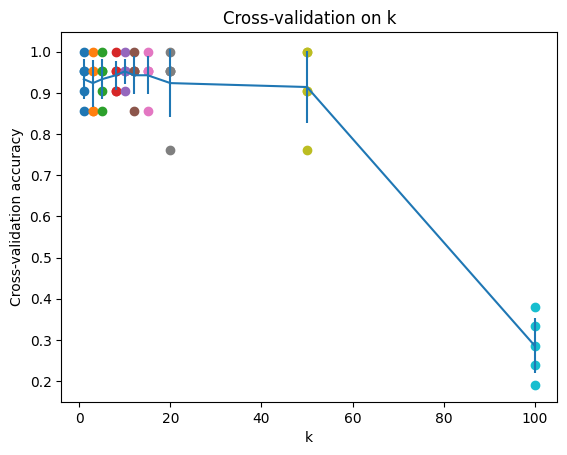

In [11]:
# 打印不同 k 值不同折数下的分类准确率
for k in k_choices:
    # 取出第k个k值的分类准确率
    accuracies = k_to_accuracies[k]
    # 绘制不同k值准确率的散点图
    plt.scatter([k] * len(accuracies), accuracies)
# 计算准确率均值并排序
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
# 计算准确率标准差并排序
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
# 绘制有置信区间的误差棒图
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
# 绘图标题
plt.title('Cross-validation on k')
# x轴标签
plt.xlabel('k')
# y轴标签
plt.ylabel('Cross-validation accuracy')
plt.show();